In [88]:
from langgraph.graph import  StateGraph,START, END
from typing import TypedDict, Literal, Annotated
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
import operator
from langchain_core.messages import SystemMessage, HumanMessage

In [89]:
generativeLLm = ChatGroq(model='llama-3.3-70b-versatile')
EvauationLLM = ChatGroq(model='llama-3.1-8b-instant')
OptimizationLLM = ChatGroq(model='openai/gpt-oss-120b')

In [90]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [91]:
structured_evaluator_llm = EvauationLLM.with_structured_output(TweetEvaluation)

In [92]:
class TweetState(TypedDict):
    topic:str
    tweet : str
    evaluation: Literal['approved', 'need_improvement']
    feedback: str
    iterations: int
    max_iteration:int

    
    tweet_history : Annotated[list[str], operator.add]
    feedback_history : Annotated[list[str], operator.add]

In [93]:
def generate_tweet(state: TweetState):
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    response = generativeLLm.invoke(messages).content
    return{'tweet': response, 'tweet_history': [response]}

In [94]:
def evaluate_tweet(state: TweetState):
    messages = [
        SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]
    response = structured_evaluator_llm.invoke(messages)

    return{'evaluation':response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [95]:
def optimize_tweet(state: TweetState):
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = OptimizationLLM.invoke(messages)
    return{'tweet': response, 'iterations': iterations , 'tweet_history': [response]}

In [96]:
def route_evaluation(state: TweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

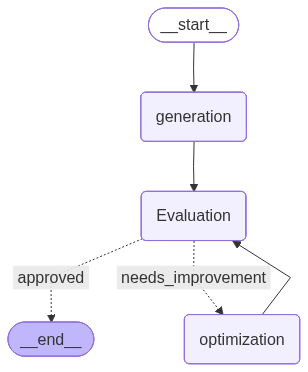

In [97]:
graph = StateGraph(TweetState)

graph.add_node('generation', generate_tweet)
graph.add_node('Evaluation', evaluate_tweet)
graph.add_node('optimization', optimize_tweet)

graph.add_edge(START,'generation')
graph.add_edge('generation', 'Evaluation')
graph.add_conditional_edges('Evaluation', route_evaluation, {'approved': END, 'needs_improvement': 'optimization'})
graph.add_edge('optimization', 'Evaluation')
workflow = graph.compile()
workflow

In [103]:
initial_state = {
    "topic": "Afaq Khan",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

In [104]:
result

{'topic': 'Afaq Khan',
 'tweet': '"Afaq Khan\'s life motto: procrastinate now, regret later" #AfaqKhanVibes',
 'evaluation': 'approved',
 'feedback': "The tweet is original and has a clear punchline that immediately conveys the humor. Afaq Khan's name is cleverly used to add a relatable touch. However, it could benefit from a bit more creativity and nuance in its humor, as it's still somewhat of a straightforward punchline without much depth or surprise.",
 'max_iteration': 5,
 'tweet_history': ['"Afaq Khan\'s life motto: procrastinate now, regret later" #AfaqKhanVibes'],
 'feedback_history': ["The tweet is original and has a clear punchline that immediately conveys the humor. Afaq Khan's name is cleverly used to add a relatable touch. However, it could benefit from a bit more creativity and nuance in its humor, as it's still somewhat of a straightforward punchline without much depth or surprise."]}

In [100]:
for tweet in result['tweet_history']:
    print(tweet)

"Datics: where dating apps meet math problems. Swiping right on 50% chance of ghosting"
